# Final Model Comparison: LSTM vs LightGBM vs Baseline

## Introduction

This notebook provides a comprehensive comparison of three approaches to vessel trajectory prediction across multiple time horizons:

1. **Baseline**: Linear extrapolation based on current position, speed, and course
2. **LightGBM (tuned)**: Gradient boosting machine with optimized hyperparameters
3. **LSTM**: Deep learning time series model using stacked LSTM layers

### Objective

Evaluate and compare model performance on a **held-out test set** to determine:
- Which approach performs best at different prediction horizons (1h, 6h, 12h, 24h)
- The practical impact of model improvements in terms of search area reduction (km²)
- The transition point where ML/DL models outperform the simple baseline



In [1]:
# ====== SYSTEM IMPORTS ======
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# ====== STANDARD LIBRARIES ======
import pandas as pd
import numpy as np

# ====== TENSORFLOW/KERAS (MODULAR APPROACH) ======
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import callbacks, optimizers, losses

# ====== LOCAL MODULES ======
from ml_logic.data_preprocessing import clean_data, resample_pings, create_LSTM_sets, scale_LSTM_data, vessel_train_test_split
from ml_logic.metric import HaversineMAE, haversine_mae, position_extrapolation
from ml_logic.feature_engineering import create_time_series_features

# ====== SKLEARN ======
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor

# ====== JUPYTER MAGIC ======
%load_ext autoreload
%autoreload 2

## 1. Data Loading and Preprocessing

Load raw AIS data and apply cleaning/resampling to prepare sequences for both LSTM and ML models.


In [2]:
# get initial data frame
df = pd.read_parquet("../data/raw/AIS_merged_lon-95.0to-77.2_lat22.5to29.5_20241101to20241130.parquet")

## 2. Configuration Setup

Define prediction horizons and training parameters. The same horizons are used for both LSTM and ML models to ensure fair comparison.


In [3]:
#clean data
df = clean_data(df)
#resample data
df_resampled = resample_pings(df, interval="10min")

/Users/pablorougerie/code/Projets/shanty_project/ml_logic/data_preprocessing.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dimension_cols] = df[dimension_cols].replace(0, np.nan)


In [4]:
# LSTM Configurations
configurations = [
    (12, 6, "1h"),   # lookback 2h, horizon 1h
    (36, 36, "6h"),  # lookback 6h, horizon 6h
    (72, 72, "12h"), # lookback 12h, horizon 12h
    (96, 144, "24h"), # lookback 16h, horizon 24h
]

# Training Parameters
n_train = 200000
n_val = 60000
n_test = 60000

batch_size = 256
epochs = 30
random_state = 273

## 3. LSTM Model Architecture and Training Function

Define the LSTM architecture and training pipeline. The model processes sequences of vessel states and predicts future positions on the test set.

In [ ]:
# ====== INITIALIZE RESULTS STORAGE ======
# Global DataFrame to store all results across configurations
import gc

if 'lstm_results_df' not in globals():
    lstm_results_df = pd.DataFrame()
    print("Results DataFrame initialized")
else:
    print(f"Results DataFrame already exists with {len(lstm_results_df)} configurations")


✓ Results DataFrame initialized


In [ ]:
# ====== MODEL ARCHITECTURE ======
def create_model(time_sequence_length, n_features, n_targets):
    """Create LSTM model architecture"""
    model = models.Sequential([
        layers.Input(shape=(time_sequence_length, n_features)),
        layers.GaussianNoise(0.0005),
        layers.LSTM(units=128, return_sequences=True, activation="tanh", recurrent_dropout=0),
        layers.Dropout(0.0),
        layers.LSTM(units=64, return_sequences=False, activation="tanh", recurrent_dropout=0),
        layers.Dropout(0.0),
        layers.Dense(32, activation="relu"),
        layers.Dense(n_targets)
    ])
    return model

# ====== HELPER FUNCTION FOR ONE CONFIGURATION ======
import matplotlib.pyplot as plt

def train_lstm_config(lookback_steps, horizon_steps, horizon_name):
    """
    Train LSTM for one configuration and save results to global DataFrame.

    Returns:
        history: Training history for plotting
    """
    print(f"\n{'='*60}")
    print(f"Configuration: {horizon_name} (lookback={lookback_steps*10}min, horizon={horizon_steps*10}min)")
    print(f"Total sequence length needed: {lookback_steps + horizon_steps} steps ({(lookback_steps + horizon_steps)*10}min)")
    print(f"{'='*60}\n")

    # 1. Create LSTM datasets
    print("1. Creating LSTM datasets...")
    X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq = create_LSTM_sets(
        df=df_resampled,
        lookback=lookback_steps,
        horizon=horizon_steps,
        test_size=0.2,
        val_size=0.2,
        random_state=random_state,
        min_nb_seq=200
    )

    # Extract data statistics
    n_train_sequences = X_train_seq.shape[0]
    n_val_sequences = X_val_seq.shape[0]
    n_test_sequences = X_test_seq.shape[0]

    print(f"\n   Available sequences:")
    print(f"      Train: {n_train_sequences:,} sequences")
    print(f"      Val: {n_val_sequences:,} sequences")
    print(f"      Test: {n_test_sequences:,} sequences")



    # 2. Scale datasets
    print("\n2. Scaling datasets...")
    X_train_sc, X_val_sc, X_test_sc = scale_LSTM_data(
        X_train=X_train_seq,
        X_val=X_val_seq,
        X_test=X_test_seq
    )

    # 3. Sample for training
    print("3. Sampling datasets...")
    np.random.seed(random_state)
    train_indices = np.random.choice(len(X_train_sc), min(n_train, len(X_train_sc)), replace=False)
    val_indices = np.random.choice(len(X_val_sc), min(n_val, len(X_val_sc)), replace=False)
    test_indices = np.random.choice(len(X_test_sc), min(n_test, len(X_test_sc)), replace=False)

    X_train_debug = X_train_sc[train_indices]
    y_train_debug = y_train_seq[train_indices]
    X_val_debug = X_val_sc[val_indices]
    y_val_debug = y_val_seq[val_indices]
    X_test_debug = X_test_sc[test_indices]
    y_test_debug = y_test_seq[test_indices]

    print(f"   Sampled: Train={len(X_train_debug):,}, Val={len(X_val_debug):,}, Test={len(X_test_debug):,}")

    # 4. Create model
    print("4. Creating model...")
    model = create_model(
        time_sequence_length=X_train_sc.shape[1],
        n_features=X_train_sc.shape[-1],
        n_targets=2
    )

    # 5. Compile
    print("5. Compiling model...")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0005, clipnorm=1.0),
        loss=losses.Huber(delta=0.3),
        metrics=[HaversineMAE(name="haversine_mae")]
    )

    # 6. Callbacks
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss', mode='min', factor=0.5, patience=6, verbose=1, min_lr=1e-5
    )
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss', mode='min', patience=8, restore_best_weights=True, verbose=1
    )

    # 7. Fit
    print("6. Training model...")
    history = model.fit(
        X_train_debug, y_train_debug,
        validation_data=(X_val_debug, y_val_debug),
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # 8. Evaluate on TEST set
    print("7. Evaluating on TEST set...")
    test_results = model.evaluate(X_test_debug, y_test_debug, batch_size=batch_size, verbose=1)
    test_loss = test_results[0]
    test_haversine_mae = test_results[1]

    best_val_mae = min(history.history['val_haversine_mae'])
    best_epoch = history.history['val_haversine_mae'].index(best_val_mae) + 1

    # 9. Plot training curves
    print("8. Plotting training curves...")
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{horizon_name} - Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['haversine_mae'], label='Train MAE', linewidth=2)
    plt.plot(history.history['val_haversine_mae'], label='Val MAE', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Haversine MAE (km)')
    plt.title(f'{horizon_name} - Haversine MAE')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 10. Save to global DataFrame
    new_row = pd.DataFrame([{
        'horizon_name': horizon_name,
        'lookback_min': lookback_steps * 10,
        'horizon_min': horizon_steps * 10,
        'test_haversine_mae': test_haversine_mae,
        'test_loss': test_loss,
        'best_epoch': best_epoch,
        'best_val_mae': best_val_mae,
        'n_train_sampled': len(X_train_debug),
        'n_val_sampled': len(X_val_debug),
        'n_test_sampled': len(X_test_debug),
        'n_train_available': n_train_sequences,
        'n_val_available': n_val_sequences,
        'n_test_available': n_test_sequences
    }])

    global lstm_results_df
    lstm_results_df = pd.concat([lstm_results_df, new_row], ignore_index=True)

    print(f"\n{horizon_name} completed: Test MAE = {test_haversine_mae:.2f} km (best val at epoch {best_epoch})")
    print(f"Results saved. Total configurations: {len(lstm_results_df)}")
    print(f"\nCurrent results summary:")
    print(lstm_results_df[['horizon_name', 'horizon_min', 'test_haversine_mae', 'best_epoch']].to_string(index=False))

    # 11. Clean memory
    del model, X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq
    del X_train_sc, X_val_sc, X_test_sc, X_train_debug, y_train_debug, X_val_debug, y_val_debug, X_test_debug, y_test_debug
    tf.keras.backend.clear_session()
    gc.collect()

    return history


## 4. LSTM Training

Train LSTM models for different prediction horizons. Each configuration is evaluated on the test set to ensure fair comparison with ML models.

### Configuration 1: 1-hour Horizon



Configuration: 1h (lookback=120min, horizon=60min)
Total sequence length needed: 18 steps (180min)

1. Creating LSTM datasets...
Created targets: 4276352 rows remaining after shift(-6)
Train: 2830741 rows, 1542 vessels | Val: 667634 rows, 386 vessels | Test: 777977 rows, 483 vessels
group_train: 0            3791472
1            3791472
2            3791472
3            3791472
4            3791472
             ...    
4290863    720202000
4290864    720202000
4290865    720202000
4290866    720202000
4290867    720202000
Name: MMSI, Length: 2830741, dtype: int64
Eligible vessels: 1356 train, 337 val, 423 test

=== Creating TRAIN sequences ===
Creating sliding windows for 1356 vessels...
  Processing vessel 50/1356 (MMSI: 215896000) - 1136 sequences
  Processing vessel 100/1356 (MMSI: 229723000) - 3715 sequences
  Processing vessel 150/1356 (MMSI: 244130525) - 1619 sequences
  Processing vessel 200/1356 (MMSI: 255806302) - 2271 sequences
  Processing vessel 250/1356 (MMSI: 258602000) 

2025-12-23 23:25:34.230240: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-12-23 23:25:34.230334: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-12-23 23:25:34.230345: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1766528734.230362 7846656 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1766528734.230422 7846656 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2025-12-23 23:25:34.814510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - haversine_mae: 2495.1343 - loss: 4.1598 - val_haversine_mae: 498.9885 - val_loss: 0.8692 - learning_rate: 5.0000e-04
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - haversine_mae: 348.6266 - loss: 0.5773 - val_haversine_mae: 155.9327 - val_loss: 0.1967 - learning_rate: 5.0000e-04
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - haversine_mae: 79.5045 - loss: 0.0929 - val_haversine_mae: 24.1177 - val_loss: 0.0168 - learning_rate: 5.0000e-04
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - haversine_mae: 17.1264 - loss: 0.0101 - val_haversine_mae: 17.9269 - val_loss: 0.0108 - learning_rate: 5.0000e-04
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - haversine_mae: 14.8428 - loss: 0.0077 - val_haversine_mae: 17.1961 - val_loss: 0.0086 - learning_rate: 5.0000e-04
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - haversine_mae: 12.0474 - loss: 0.0054 - val_haversine_mae: 11.2206 - val_loss: 0.0048 - learning_rat

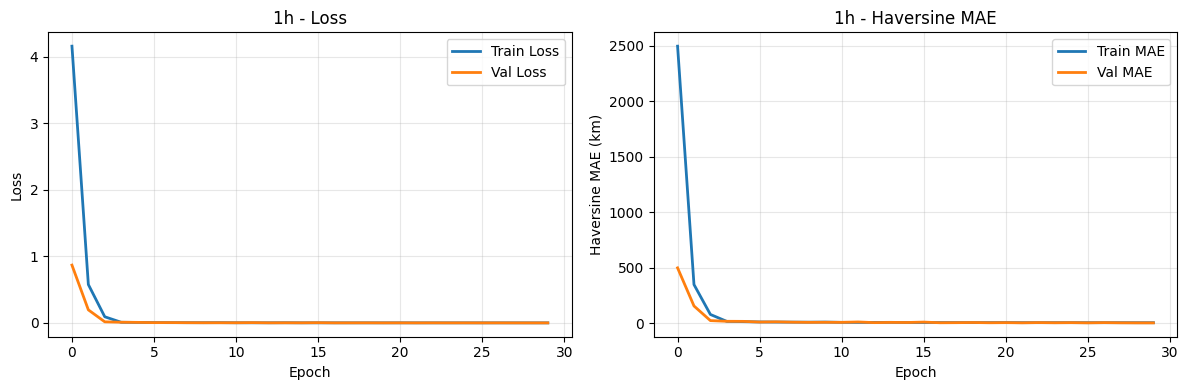


✓ 1h completed: Test MAE = 3.84 km (best val at epoch 30)
✓ Results saved. Total configurations: 1

Current results summary:
horizon_name  horizon_min  test_haversine_mae  best_epoch
          1h           60            3.840753          30


In [7]:
# Configuration 1h: lookback 2h, horizon 1h
history_1h = train_lstm_config(lookback_steps=12, horizon_steps=6, horizon_name="1h")


### Configuration 2: 6-hour Horizon



Configuration: 6h (lookback=360min, horizon=360min)
Total sequence length needed: 72 steps (720min)

1. Creating LSTM datasets...
Created targets: 4204534 rows remaining after shift(-36)
Train: 2710578 rows, 1518 vessels | Val: 650909 rows, 380 vessels | Test: 843047 rows, 475 vessels
group_train: 0            3791472
1            3791472
2            3791472
3            3791472
4            3791472
             ...    
4288891    720066000
4288892    720066000
4288893    720066000
4288894    720066000
4288895    720066000
Name: MMSI, Length: 2710578, dtype: int64
Eligible vessels: 1296 train, 321 val, 408 test

=== Creating TRAIN sequences ===
Creating sliding windows for 1296 vessels...
  Processing vessel 50/1296 (MMSI: 215873000) - 549 sequences
  Processing vessel 100/1296 (MMSI: 229723000) - 3661 sequences
  Processing vessel 150/1296 (MMSI: 244168000) - 3311 sequences
  Processing vessel 200/1296 (MMSI: 255806206) - 872 sequences
  Processing vessel 250/1296 (MMSI: 257919000) 

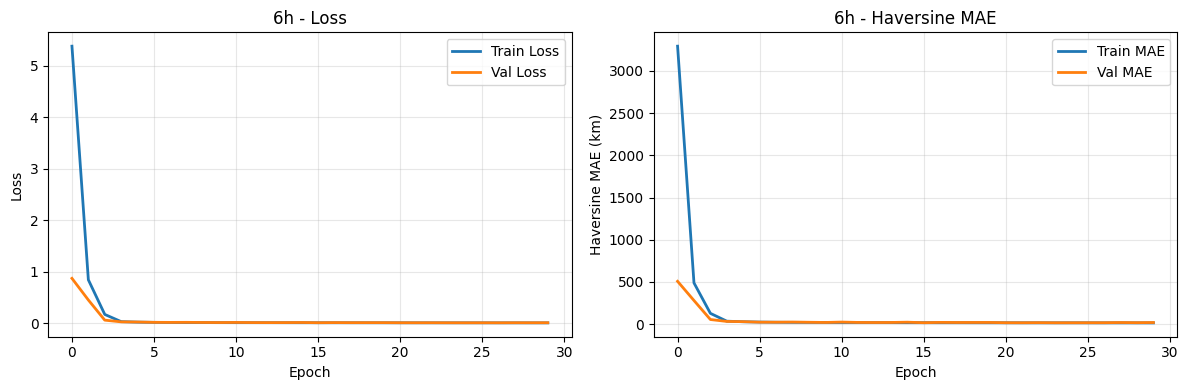


✓ 6h completed: Test MAE = 16.48 km (best val at epoch 24)
✓ Results saved. Total configurations: 2

Current results summary:
horizon_name  horizon_min  test_haversine_mae  best_epoch
          1h           60            3.840753          30
          6h          360           16.477526          24


In [8]:
# Configuration 6h: lookback 6h, horizon 6h
history_6h = train_lstm_config(lookback_steps=36, horizon_steps=36, horizon_name="6h")


### Configuration 3: 12-hour Horizon



Configuration: 12h (lookback=720min, horizon=720min)
Total sequence length needed: 144 steps (1440min)

1. Creating LSTM datasets...
Created targets: 4120299 rows remaining after shift(-72)
Train: 2651894 rows, 1478 vessels | Val: 687687 rows, 370 vessels | Test: 780718 rows, 462 vessels
group_train: 0            3791472
1            3791472
2            3791472
3            3791472
4            3791472
             ...    
4290797    720202000
4290798    720202000
4290799    720202000
4290800    720202000
4290801    720202000
Name: MMSI, Length: 2651894, dtype: int64
Eligible vessels: 1236 train, 315 val, 396 test

=== Creating TRAIN sequences ===
Creating sliding windows for 1236 vessels...
  Processing vessel 50/1236 (MMSI: 215933000) - 400 sequences
  Processing vessel 100/1236 (MMSI: 232012089) - 1511 sequences
  Processing vessel 150/1236 (MMSI: 245347000) - 1223 sequences
  Processing vessel 200/1236 (MMSI: 256278000) - 718 sequences
  Processing vessel 250/1236 (MMSI: 30327000

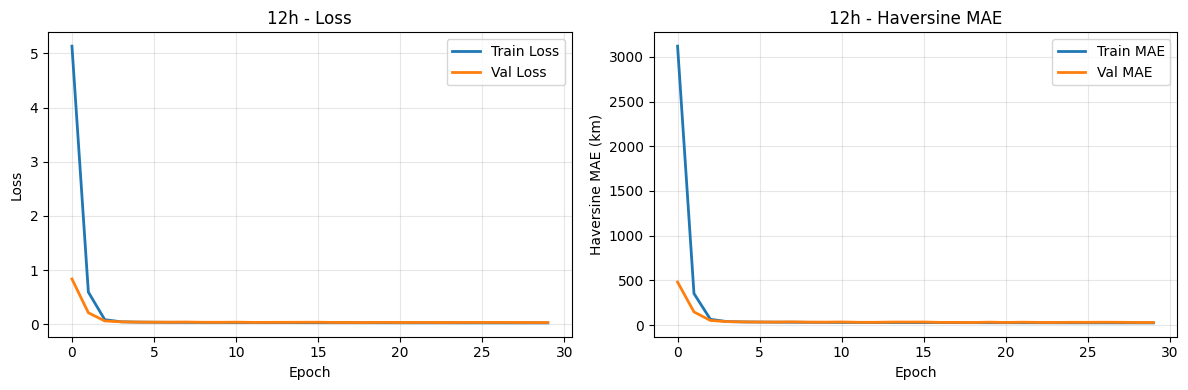


✓ 12h completed: Test MAE = 28.72 km (best val at epoch 29)
✓ Results saved. Total configurations: 3

Current results summary:
horizon_name  horizon_min  test_haversine_mae  best_epoch
          1h           60            3.840753          30
          6h          360           16.477526          24
         12h          720           28.722311          29


In [9]:
# Configuration 12h: lookback 12h, horizon 12h
history_12h = train_lstm_config(lookback_steps=72, horizon_steps=72, horizon_name="12h")


### Configuration 4: 24-hour Horizon



Configuration: 24h (lookback=960min, horizon=1440min)
Total sequence length needed: 240 steps (2400min)

1. Creating LSTM datasets...
Created targets: 3958145 rows remaining after shift(-144)
Train: 2584707 rows, 1410 vessels | Val: 616447 rows, 353 vessels | Test: 756991 rows, 441 vessels
group_train: 0            3791472
1            3791472
2            3791472
3            3791472
4            3791472
             ...    
4290725    720202000
4290726    720202000
4290727    720202000
4290728    720202000
4290729    720202000
Name: MMSI, Length: 2584707, dtype: int64
Eligible vessels: 1169 train, 285 val, 337 test

=== Creating TRAIN sequences ===
Creating sliding windows for 1169 vessels...
  Processing vessel 50/1169 (MMSI: 219000034) - 787 sequences
  Processing vessel 100/1169 (MMSI: 232045875) - 1435 sequences
  Processing vessel 150/1169 (MMSI: 248006000) - 430 sequences
  Processing vessel 200/1169 (MMSI: 257083330) - 1327 sequences
  Processing vessel 250/1169 (MMSI: 304844

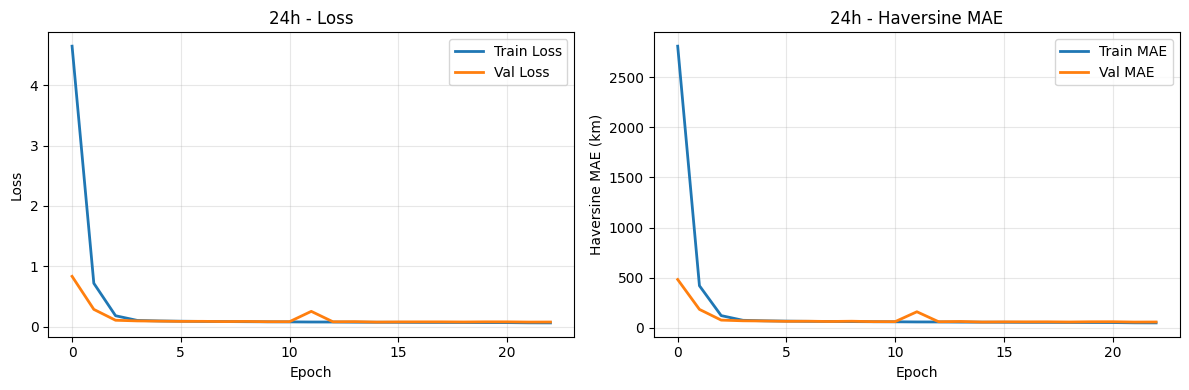


✓ 24h completed: Test MAE = 62.44 km (best val at epoch 22)
✓ Results saved. Total configurations: 4

Current results summary:
horizon_name  horizon_min  test_haversine_mae  best_epoch
          1h           60            3.840753          30
          6h          360           16.477526          24
         12h          720           28.722311          29
         24h         1440           62.444740          22


In [10]:
# Configuration 24h: lookback 16h, horizon 24h
history_24h = train_lstm_config(lookback_steps=96, horizon_steps=144, horizon_name="24h")


## 5. Machine Learning Models Setup

Define the LightGBM model with tuned hyperparameters from previous notebook analysis.

In [15]:
### Define models
models = {
    "LightGBM (tuned)": LGBMRegressor(
        n_estimators=400,  # Updated from grid search
        max_depth=8,  # Updated from grid search
        learning_rate=0.1,  # Updated from grid search
        min_child_samples=40,  # Updated from grid search
        reg_lambda=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=273,
        n_jobs=-1,
        verbose=-1
    )
}


## 6. Data Split for ML Models

Split the resampled data into train/val/test sets for ML models. The split ensures no vessel overlap between sets, consistent with the LSTM workflow.


## 7. LightGBM and Baseline Training

Train LightGBM models and evaluate baseline predictions on the test set across all horizons. Results are stored for comparison with LSTM.


In [16]:
### Split data
df_train, df_val, df_test, groups_train, groups_val, groups_test = vessel_train_test_split(
    df_resampled, test_size=0.2, val_size=0.15, random_state=273
)

In [ ]:
horizons = [60, 360, 720, 1440]

# Storage
results = []

features_to_remove = ["COG_lag_480min", "SOG_lag_240min", "COG_lag_240min",
                      "Heading", "COG_lag_80min"]


for horizon in horizons:
    print(f"=== Horizon: {horizon}min ({horizon/60:.1f}h) ===")

    # 1. Create features for each horizon on the already-split datasets
    df_train_horizon = create_time_series_features(df_train, target_horizon=horizon, time_step=10,
                                                    rolling=False, advanced_features=False)
    df_test_horizon = create_time_series_features(df_test, target_horizon=horizon, time_step=10,
                                                   rolling=False, advanced_features=False)

    # 2. Separate X, y for each set
    X_train_h = df_train_horizon.drop(columns=["MMSI", "BaseDateTime", "target_LAT", "target_LON"])
    y_train_h = df_train_horizon[["target_LAT", "target_LON"]]

    X_test_h = df_test_horizon.drop(columns=["MMSI", "BaseDateTime", "target_LAT", "target_LON"])
    y_test_h = df_test_horizon[["target_LAT", "target_LON"]]

    # 3. Remove features selected for deletion (if they exist for this horizon)
    # Note: feature names depend on horizon, so we filter dynamically
    horizon_features_to_remove = [f for f in features_to_remove if f in X_train_h.columns]
    if horizon_features_to_remove:
        X_train_h = X_train_h.drop(columns=horizon_features_to_remove)
        X_test_h = X_test_h.drop(columns=horizon_features_to_remove)

    # 4. Sample random rows from train for this horizon
    # Random sampling is safe since vessel_train_test_split already ensures no vessel overlap
    n_train_sample = min(n_train, len(X_train_h))

    np.random.seed(random_state)
    train_indices_h = np.random.choice(len(X_train_h), n_train_sample, replace=False)

    X_train_sampled = X_train_h.iloc[train_indices_h]
    y_train_sampled = y_train_h.iloc[train_indices_h]

    # 5. Baseline: linear extrapolation using current position, SOG, and COG
    # Evaluate on full test set (no sampling for baseline)
    LAT_pred_baseline, LON_pred_baseline = position_extrapolation(X_test_h, time_horizon=horizon)
    y_pred_baseline = np.column_stack([LAT_pred_baseline, LON_pred_baseline])
    mae_baseline = haversine_mae(y_test_h.values, y_pred_baseline)

    print(f"  Baseline: {mae_baseline:.3f} km")

    row = {
        'horizon_min': horizon,
        'Baseline': mae_baseline
    }

    # 6. Models - train on sampled train set, evaluate on full test set
    for name, model in models.items():
        multi_model = MultiOutputRegressor(model)
        multi_model.fit(X_train_sampled, y_train_sampled)
        y_pred = multi_model.predict(X_test_h)
        mae = haversine_mae(y_test_h.values, y_pred)

        print(f"  {name}: {mae:.3f} km")
        row[name] = mae

    results.append(row)
    print()

# Create DataFrame
results_df = pd.DataFrame(results)

=== Horizon: 60min (1.0h) ===
Target prediction horizon: 60 min. Number of steps: 6
Defining lag windows of 10min, 30min, 60min
Target prediction horizon: 60 min. Number of steps: 6
Defining lag windows of 10min, 30min, 60min
  Baseline: 1.548 km
  LightGBM (tuned): 4.765 km

=== Horizon: 360min (6.0h) ===
Target prediction horizon: 360 min. Number of steps: 36
Defining lag windows of 60min, 180min, 360min
Target prediction horizon: 360 min. Number of steps: 36
Defining lag windows of 60min, 180min, 360min
  Baseline: 18.406 km
  LightGBM (tuned): 16.973 km

=== Horizon: 720min (12.0h) ===
Target prediction horizon: 720 min. Number of steps: 72
Defining lag windows of 120min, 360min, 720min
Target prediction horizon: 720 min. Number of steps: 72
Defining lag windows of 120min, 360min, 720min
  Baseline: 48.231 km
  LightGBM (tuned): 34.908 km

=== Horizon: 1440min (24.0h) ===
Target prediction horizon: 1440 min. Number of steps: 144
Defining lag windows of 240min, 720min, 1440min
Targe

## 8. Final Comparison

Merge results from LSTM, LightGBM, and Baseline models to create a comprehensive comparison table and calculate performance improvements.


In [18]:
# Merge LSTM and ML results for comparison
# Rename columns for clarity
lstm_comparison = lstm_results_df[['horizon_name', 'horizon_min', 'test_haversine_mae']].copy()
lstm_comparison = lstm_comparison.rename(columns={'test_haversine_mae': 'LSTM'})

ml_comparison = results_df[['horizon_min', 'Baseline', 'LightGBM (tuned)']].copy()

# Merge on horizon_min
comparison_df = pd.merge(lstm_comparison, ml_comparison, on='horizon_min', how='inner')

# Reorder columns: Baseline, LightGBM, LSTM for each horizon
comparison_df = comparison_df[['horizon_name', 'horizon_min', 'Baseline', 'LightGBM (tuned)', 'LSTM']]

print("="*70)
print("FINAL COMPARISON: LSTM vs LightGBM vs Baseline (Test Set)")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Calculate improvements
print("\nLSTM improvements vs Baseline:")
for idx, row in comparison_df.iterrows():
    improvement = ((row['Baseline'] - row['LSTM']) / row['Baseline']) * 100
    print(f"  {row['horizon_name']}: {improvement:+.1f}%")

print("\nLSTM improvements vs LightGBM:")
for idx, row in comparison_df.iterrows():
    improvement = ((row['LightGBM (tuned)'] - row['LSTM']) / row['LightGBM (tuned)']) * 100
    print(f"  {row['horizon_name']}: {improvement:+.1f}%")


FINAL COMPARISON: LSTM vs LightGBM vs Baseline (Test Set)
horizon_name  horizon_min   Baseline  LightGBM (tuned)      LSTM
          1h           60   1.547771          4.764549  3.840753
          6h          360  18.405988         16.972837 16.477526
         12h          720  48.231285         34.908317 28.722311
         24h         1440 113.773581         71.022029 62.444740

LSTM improvements vs Baseline:
  1h: -148.1%
  6h: +10.5%
  12h: +40.4%
  24h: +45.1%

LSTM improvements vs LightGBM:
  1h: +19.4%
  6h: +2.9%
  12h: +17.7%
  24h: +12.1%


## 9. Performance Visualization

### Performance Improvement Over Baseline

Plot the percentage improvement over baseline for both LightGBM and LSTM across all tested horizons.


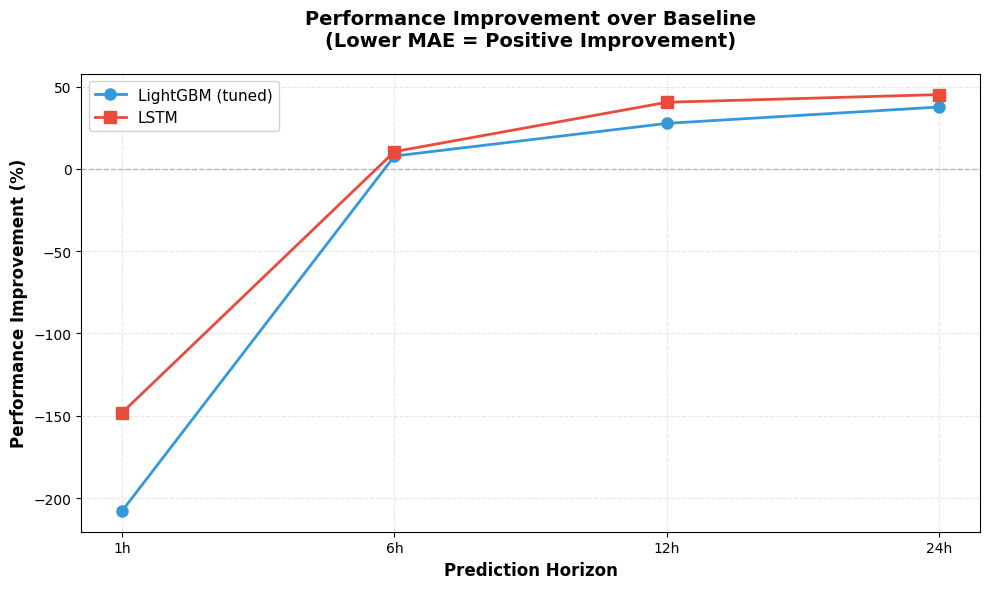


PERFORMANCE IMPROVEMENT SUMMARY
Horizon    LightGBM        LSTM           
----------------------------------------------------------------------
1h         -207.8%        -148.1%
6h            7.8%          10.5%
12h          27.6%          40.4%
24h          37.6%          45.1%


In [23]:
# Calculate percentage improvement over baseline for each model
comparison_df['LGBM_improvement'] = ((comparison_df['Baseline'] - comparison_df['LightGBM (tuned)']) / comparison_df['Baseline']) * 100
comparison_df['LSTM_improvement'] = ((comparison_df['Baseline'] - comparison_df['LSTM']) / comparison_df['Baseline']) * 100

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Extract data
horizons = comparison_df['horizon_name'].values
lgbm_improvements = comparison_df['LGBM_improvement'].values
lstm_improvements = comparison_df['LSTM_improvement'].values

# Plot lines
ax.plot(horizons, lgbm_improvements, marker='o', linewidth=2, markersize=8, label='LightGBM (tuned)', color='#3498db')
ax.plot(horizons, lstm_improvements, marker='s', linewidth=2, markersize=8, label='LSTM', color='#e74c3c')

# Add horizontal line at 0% for reference
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Customize plot
ax.set_xlabel('Prediction Horizon', fontsize=12, fontweight='bold')
ax.set_ylabel('Performance Improvement (%)', fontsize=12, fontweight='bold')
ax.set_title('Performance Improvement over Baseline\n(Lower MAE = Positive Improvement)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')


plt.tight_layout()
plt.savefig('../visualizations/performance_improvement_over_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*70)
print("PERFORMANCE IMPROVEMENT SUMMARY")
print("="*70)
print(f"{'Horizon':<10} {'LightGBM':<15} {'LSTM':<15}")
print("-"*70)
for idx, row in comparison_df.iterrows():
    print(f"{row['horizon_name']:<10} {row['LGBM_improvement']:>6.1f}%        {row['LSTM_improvement']:>6.1f}%")
print("="*70)


### Search Area Uncertainty Visualization

Plot the uncertainty area (in km²) for each model across all horizons. The uncertainty area represents the search area needed and is calculated as a circle with radius equal to the MAE: Area = π × MAE². This metric is critical for search and rescue operations.


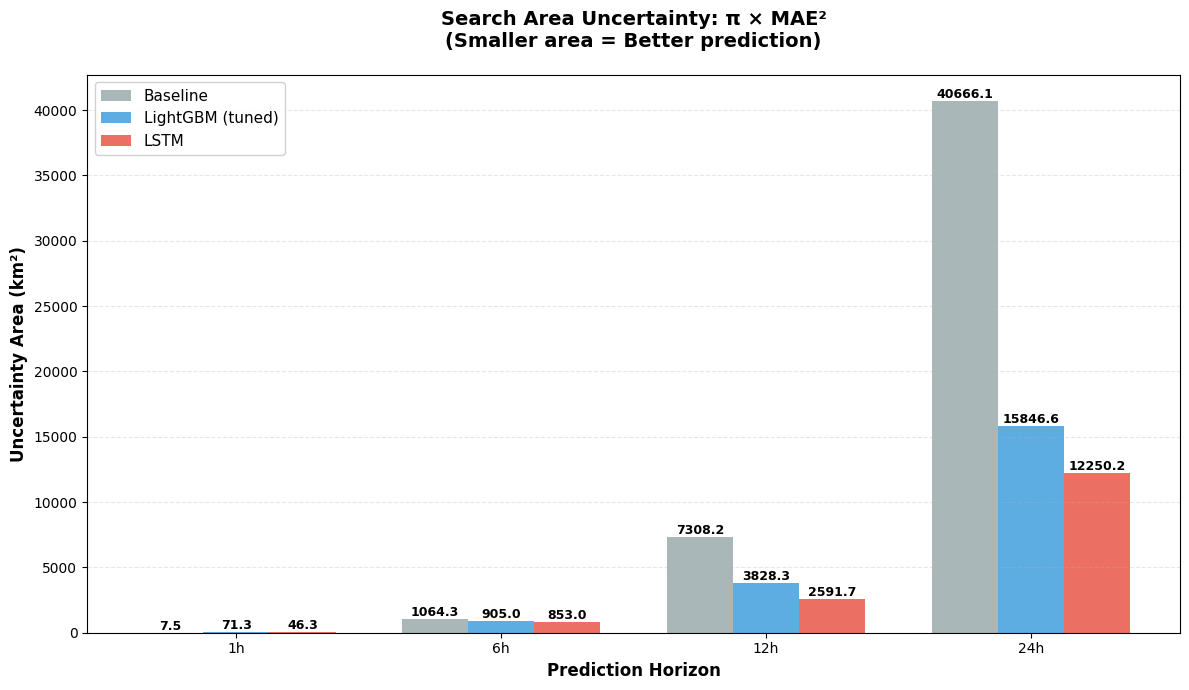


UNCERTAINTY AREA SUMMARY (km²)
Horizon    Baseline        LightGBM        LSTM            Reduction vs Baseline
--------------------------------------------------------------------------------
1h                   7.5           71.3           46.3  LGBM: -847.6%, LSTM: -515.8%
6h                1064.3          905.0          853.0  LGBM:  15.0%, LSTM:  19.9%
12h               7308.2         3828.3         2591.7  LGBM:  47.6%, LSTM:  64.5%
24h              40666.1        15846.6        12250.2  LGBM:  61.0%, LSTM:  69.9%

TOTAL AREA REDUCTION (sum across all horizons)
Baseline total area: 49046.1 km²
LightGBM total area: 20651.3 km² (reduction: 57.9%)
LSTM total area: 15741.2 km² (reduction: 67.9%)


In [22]:
# Calculate uncertainty area (π × MAE²) for each model in km²
comparison_df['Baseline_area'] = np.pi * (comparison_df['Baseline'] ** 2)
comparison_df['LGBM_area'] = np.pi * (comparison_df['LightGBM (tuned)'] ** 2)
comparison_df['LSTM_area'] = np.pi * (comparison_df['LSTM'] ** 2)

# Prepare data for bar plot
horizons = comparison_df['horizon_name'].values
baseline_areas = comparison_df['Baseline_area'].values
lgbm_areas = comparison_df['LGBM_area'].values
lstm_areas = comparison_df['LSTM_area'].values

# Set up the bar positions
x = np.arange(len(horizons))
width = 0.25  # Width of bars

# Create the bar plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot bars
bars1 = ax.bar(x - width, baseline_areas, width, label='Baseline', color='#95a5a6', alpha=0.8)
bars2 = ax.bar(x, lgbm_areas, width, label='LightGBM (tuned)', color='#3498db', alpha=0.8)
bars3 = ax.bar(x + width, lstm_areas, width, label='LSTM', color='#e74c3c', alpha=0.8)

# Customize plot
ax.set_xlabel('Prediction Horizon', fontsize=12, fontweight='bold')
ax.set_ylabel('Uncertainty Area (km²)', fontsize=12, fontweight='bold')
ax.set_title('Search Area Uncertainty: π × MAE²\n(Smaller area = Better prediction)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(horizons)
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.tight_layout()
plt.savefig('../visualizations/search_area_uncertainty.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary table
print("\n" + "="*80)
print("UNCERTAINTY AREA SUMMARY (km²)")
print("="*80)
print(f"{'Horizon':<10} {'Baseline':<15} {'LightGBM':<15} {'LSTM':<15} {'Reduction vs Baseline':<20}")
print("-"*80)
for idx, row in comparison_df.iterrows():
    baseline_area = row['Baseline_area']
    lgbm_area = row['LGBM_area']
    lstm_area = row['LSTM_area']
    lgbm_reduction = ((baseline_area - lgbm_area) / baseline_area) * 100
    lstm_reduction = ((baseline_area - lstm_area) / baseline_area) * 100

    print(f"{row['horizon_name']:<10} {baseline_area:>13.1f}  {lgbm_area:>13.1f}  {lstm_area:>13.1f}  "
          f"LGBM: {lgbm_reduction:>5.1f}%, LSTM: {lstm_reduction:>5.1f}%")
print("="*80)

# Calculate total area reduction
print("\n" + "="*80)
print("TOTAL AREA REDUCTION (sum across all horizons)")
print("="*80)
total_baseline = comparison_df['Baseline_area'].sum()
total_lgbm = comparison_df['LGBM_area'].sum()
total_lstm = comparison_df['LSTM_area'].sum()
total_reduction_lgbm = ((total_baseline - total_lgbm) / total_baseline) * 100
total_reduction_lstm = ((total_baseline - total_lstm) / total_baseline) * 100

print(f"Baseline total area: {total_baseline:.1f} km²")
print(f"LightGBM total area: {total_lgbm:.1f} km² (reduction: {total_reduction_lgbm:.1f}%)")
print(f"LSTM total area: {total_lstm:.1f} km² (reduction: {total_reduction_lstm:.1f}%)")
print("="*80)


## Conclusion

### Model Dominance by Horizon

**1-hour horizon:**
- **Baseline dominates**: 1.55 km MAE (vs 4.76 km LightGBM, 3.84 km LSTM)
- Both ML/DL models underperform significantly 
- Constant velocity assumption is optimal for short-term predictions

**6-hour horizon:**
- **LSTM leads**: 16.48 km MAE (vs 16.97 km LightGBM, 18.41 km Baseline)
- Transition point where ML/DL models begin to outperform baseline
- LSTM shows slight advantage over LightGBM (+2.9%)

**12-hour and 24-hour horizons:**
- **LSTM dominates**: 28.72 km (12h) and 62.44 km (24h) MAE
- Outperforms LightGBM by 17.7% (12h) and 12.1% (24h)
- Outperforms baseline by 40.4% (12h) and 45.1% (24h)
- Deep learning's ability to capture long-term temporal dependencies is critical

### Impact of ML/DL Models

**Performance improvements over baseline:**
- **6h**: LightGBM +7.8%, LSTM +10.5%
- **12h**: LightGBM +27.6%, LSTM +40.4%
- **24h**: LightGBM +37.6%, LSTM +45.1%

**Search area reduction:**
- **6h**: LightGBM saves 159 km² (15.0%), LSTM saves 211 km² (19.9%)
- **12h**: LightGBM saves 3,480 km² (47.6%), LSTM saves 4,716 km² (64.5%)
- **24h**: LightGBM saves 24,820 km² (61.0%), LSTM saves 28,416 km² (69.9%)
- **Total across all horizons**: LSTM reduces search area by 67.9% (33,305 km² saved), outperforming LightGBM by 9.0% additional reduction

### General Commentary

**Key findings:**
1. **Horizon-dependent performance**: No single model dominates across all horizons. Baseline is optimal for 1h, while LSTM excels for longer horizons (≥6h).

2. **ML/DL value proposition**: Machine learning and deep learning models provide substantial value for horizons ≥6h, with improvements increasing with prediction distance. The transition from baseline dominance to ML/DL superiority occurs around 3-6 hours.

3. **LSTM superiority**: LSTM's advantage over LightGBM increases with horizon length (2.9% at 6h, 17.7% at 12h, 12.1% at 24h), demonstrating the value of temporal sequence learning for capturing complex trajectory patterns.

4. **Operational impact**: Search area reductions translate to significant operational benefits. At 24h, LSTM reduces search area by 28,416 km² (69.9%) compared to baseline, directly improving search and rescue efficiency and reducing resource requirements.

**Limitations:**
- Both ML/DL models fail to outperform baseline on 1h horizon, suggesting need for different architectures or features for short-term predictions
- LSTM requires more computational resources but provides clear performance benefits on longer horizons
- Single test set evaluation (no confidence intervals) limits statistical certainty

**Final assessment:**
Deep learning (LSTM) provides the best performance for vessel trajectory prediction on horizons ≥6h, with substantial improvements in both prediction accuracy (10-45% better than baseline) and search area reduction (20-70% reduction). The practical impact is significant for search and rescue operations, where reduced search areas directly translate to improved efficiency and resource allocation.